# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns

from scipy.stats import ttest_rel, ttest_ind
import numpy as np
import os
import yaml
import shutil

from matplotlib.ticker import MaxNLocator
from deep_experiments.utils import load_experiment_dirs, quick_load_experiments_tsv
from utils import add_stats, load_probing_dirs

%load_ext autoreload
%autoreload 2

%matplotlib inline

# Szeged UD POS

In [2]:
szeged_pos = pd.read_table("../results/szeged_pos.tsv", na_filter=None, quoting=3)
model_order = [
    'huBERT',
    'mBERT',
    'XLM-RoBERTa',
    'XLM-MLM-100',
    'distil-mBERT',
]
szeged_pos['model'] = pd.Categorical(szeged_pos['model'], ordered=True, categories=model_order)
szeged_pos.head()

,model,subword_pooling,layer_pooling,dev_acc,test_acc
0,huBERT,first,0,0.895341,0.884667
1,huBERT,first,0,0.895341,0.883901
2,huBERT,first,0,0.896129,0.886007
3,huBERT,first,1,0.938956,0.928599
4,huBERT,first,1,0.936854,0.928120


In [3]:
s = szeged_pos.groupby(['model', 'layer_pooling', 'subword_pooling']).dev_acc.mean().unstack()
s.reset_index().groupby('model').max()

subword_pooling,layer_pooling,first,last
model,,,
huBERT,16,0.962077,0.974689
mBERT,16,0.943890,0.962778
XLM-RoBERTa,16,0.954137,0.970106
XLM-MLM-100,16,0.954458,0.965347
distil-mBERT,16,0.901296,0.930957


In [4]:
def get_weighted_layer(group):
    return (group.dev_acc * group.layer_pooling.astype(int)).mean()
    
szeged_pos.groupby(['model', 'subword_pooling']).apply(get_weighted_layer).unstack().round(0)

subword_pooling,first,last
model,,
huBERT,6.0,6.0
mBERT,6.0,6.0
XLM-RoBERTa,6.0,6.0
XLM-MLM-100,8.0,8.0
distil-mBERT,3.0,3.0


## Szeged test accuracy

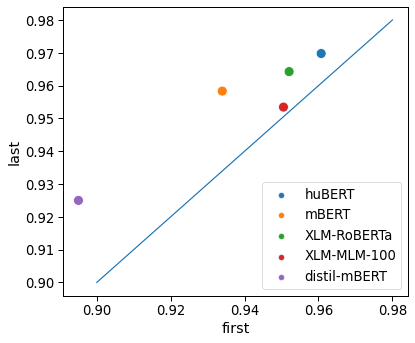

In [5]:
sz = szeged_pos.groupby(['model', 'subword_pooling', 'layer_pooling']).dev_acc.mean().unstack().idxmax(axis=1)
sz.name = 'best_layer'
best_layers = sz.reset_index().values
best_layers = tuple(tuple(t) for t in best_layers)

def is_best_layer(row):
    return (row.model, row.subword_pooling, row.layer_pooling) in best_layers


szeged_best = szeged_pos[szeged_pos.apply(is_best_layer, axis=1)]
szeged_best = szeged_best.groupby(['model', 'subword_pooling']).test_acc.mean().unstack(1).reset_index()

with sns.plotting_context('paper', font_scale=1.5):
    fig, ax = plt.subplots(1, figsize=(6, 5))
    ax = sns.scatterplot(x=szeged_best['first'], y=szeged_best['last'], hue=szeged_best['model'], s=100, ax=ax)
    ax.legend(loc='lower right')
    min_ = 0.9
    max_ = 0.98
    ax.plot((min_, max_), (min_, max_))
    plt.tight_layout()

In [6]:
szeged_best = szeged_pos[szeged_pos.apply(is_best_layer, axis=1)]

sign = []
for (model1, pooling1), group1 in szeged_best.groupby(['model', 'subword_pooling']):
    test_acc1 = group1.test_acc
    for (model2, pooling2), group2 in szeged_best.groupby(['model', 'subword_pooling']):
        test_acc2 = group2.test_acc
        p = ttest_ind(test_acc1, test_acc2)[1]
        sign.append({
            'model1': model1,
            'pooling1': pooling1,
            'test_acc1': test_acc1.mean(),
            'model2': model2,
            'pooling2': pooling2,
            'test_acc2': test_acc2.mean(),
            'p': p,
        })
sign = pd.DataFrame(sign)

In [7]:
sign['significant'] = sign['p'] < 0.05

All differences are **significant**:

In [8]:
s = sign[(sign.pooling1=='first') & (sign.pooling2=='first')]
s.pivot(index='model1', columns='model2', values='significant')

model2,XLM-MLM-100,XLM-RoBERTa,distil-mBERT,huBERT,mBERT
model1,,,,,
XLM-MLM-100,False,True,True,True,True
XLM-RoBERTa,True,False,True,True,True
distil-mBERT,True,True,False,True,True
huBERT,True,True,True,False,True
mBERT,True,True,True,True,False


In [9]:
s = sign[(sign.pooling1=='last') & (sign.pooling2=='last')]
s.pivot(index='model1', columns='model2', values='significant')

model2,XLM-MLM-100,XLM-RoBERTa,distil-mBERT,huBERT,mBERT
model1,,,,,
XLM-MLM-100,False,True,True,True,True
XLM-RoBERTa,True,False,True,True,True
distil-mBERT,True,True,False,True,True
huBERT,True,True,True,False,True
mBERT,True,True,True,True,False


In [10]:
def is_middle_layer(row):
    midlayer = {
        'XLM-MLM-100': 8,
        'mBERT': 6,
        'XLM-RoBERTa': 6,
        'huBERT': 6,
        'distil-mBERT': 3,
    }
    if 'sum' in str(row.layer_pooling):
        return False
    return int(row.layer_pooling) == midlayer[row.model]


def is_highest_layer(row):
    layer_num = {
        'XLM-MLM-100': 16,
        'mBERT': 12,
        'XLM-RoBERTa': 12,
        'huBERT': 12,
        'distil-mBERT': 6,
    }
    if 'sum' in str(row.layer_pooling):
        return False
    return int(row.layer_pooling) == layer_num[row.model]

In [11]:
szeged_pos[szeged_pos['model'].isnull()]

,model,subword_pooling,layer_pooling,dev_acc,test_acc


In [12]:
szeged_pos['model'].value_counts(dropna=False)

XLM-MLM-100     102
huBERT           78
mBERT            78
XLM-RoBERTa      78
distil-mBERT     42
Name: model, dtype: int64

In [13]:
metric = 'test_acc'
lowest_layer = szeged_pos[szeged_pos.layer_pooling.astype(str)=="0"]
middle_layer = szeged_pos[szeged_pos.apply(is_middle_layer, axis=1)]
highest_layer = szeged_pos[szeged_pos.apply(is_highest_layer, axis=1)]
first_layer = szeged_pos[szeged_pos.layer_pooling.astype(str)=="1"]

lowest_layer = lowest_layer.groupby(['model', 'subword_pooling'])[metric].mean()
lowest_layer = lowest_layer.reset_index()

first_layer = first_layer.groupby(['model', 'subword_pooling'])[metric].mean()
first_layer = first_layer.reset_index()

middle_layer = middle_layer.groupby(['model', 'subword_pooling'])[metric].mean()
middle_layer = middle_layer.reset_index()

highest_layer = highest_layer.groupby(['model', 'subword_pooling'])[metric].mean()
highest_layer = highest_layer.reset_index()

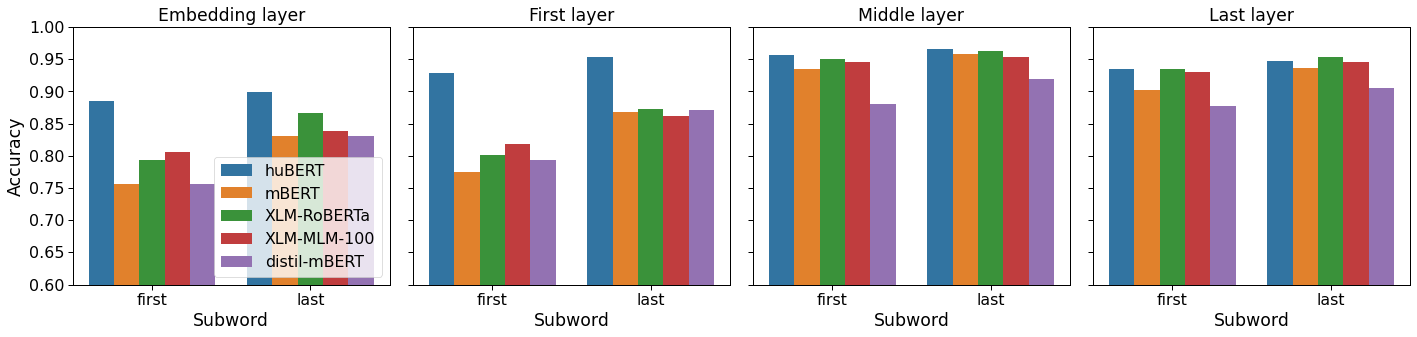

In [14]:
with sns.plotting_context('paper', font_scale=1.8):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

    sns.barplot(x=lowest_layer['subword_pooling'], y=lowest_layer[metric], hue=lowest_layer['model'], ax=axes[0])
    axes[0].set_ylim(0.6, 1)
    axes[0].legend(markerscale=2, loc='lower right')
    axes[0].set_title("Embedding layer")
    axes[0].set_xlabel("Subword")
    axes[0].set_ylabel("Accuracy")

    sns.barplot(x=first_layer['subword_pooling'], y=first_layer[metric], hue=first_layer['model'], ax=axes[1])
    axes[1].get_legend().remove()
    axes[1].set_title("First layer")
    axes[1].set_xlabel("Subword")
    axes[1].set_ylabel("")

    sns.barplot(x=middle_layer['subword_pooling'], y=middle_layer[metric], hue=middle_layer['model'], ax=axes[2])
    axes[2].get_legend().remove()
    axes[2].set_title("Middle layer")
    axes[2].set_xlabel("Subword")
    axes[2].set_ylabel("")

    sns.barplot(x=highest_layer['subword_pooling'], y=highest_layer[metric], hue=highest_layer['model'], ax=axes[3])
    axes[3].get_legend().remove()
    axes[3].set_title("Last layer")
    axes[3].set_xlabel("Subword")
    axes[3].set_ylabel("")
    plt.tight_layout()
    
    fig.savefig("fig/bar_szeged_pos_low_high_layer.pdf")

# Large POS

In [15]:
pos = pd.read_table("../results/large_pos.tsv", na_filter=None, quoting=3)
model_order = [
    'huBERT',
    'mBERT',
    'XLM-RoBERTa',
    'XLM-MLM-100',
    'distil-mBERT',
]
pos['model'] = pd.Categorical(pos['model'], ordered=True, categories=model_order)
pos.head()

,model,subword_pooling,layer_pooling,dev_acc,test_acc
0,huBERT,first,3,0.964480,0.965029
1,huBERT,first,3,0.964683,0.965586
2,huBERT,first,3,0.965118,0.965293
3,huBERT,last,3,0.970603,0.969543
4,huBERT,last,3,0.969529,0.968781


Filter subword pooling other than first/last

In [16]:
pos = pos[(pos.subword_pooling.isin(('first', 'last'))) & (pos.apply(is_best_layer, axis=1))].copy()

In [17]:
pos.groupby(['model', 'subword_pooling'])['dev_acc'].mean().unstack()

subword_pooling,first,last
model,,
huBERT,0.964760,0.970284
mBERT,0.945055,0.957350
XLM-RoBERTa,0.959101,0.965631
XLM-MLM-100,0.948325,0.947890
distil-mBERT,0.918338,0.937810


In [18]:
best_layers

(('huBERT', 'first', 3),
 ('huBERT', 'last', 3),
 ('mBERT', 'first', 7),
 ('mBERT', 'last', 6),
 ('XLM-RoBERTa', 'first', 7),
 ('XLM-RoBERTa', 'last', 5),
 ('XLM-MLM-100', 'first', 9),
 ('XLM-MLM-100', 'last', 10),
 ('distil-mBERT', 'first', 4),
 ('distil-mBERT', 'last', 4))

In [19]:
p = pos.groupby(['model', 'subword_pooling'])['test_acc'].mean().unstack().reset_index()

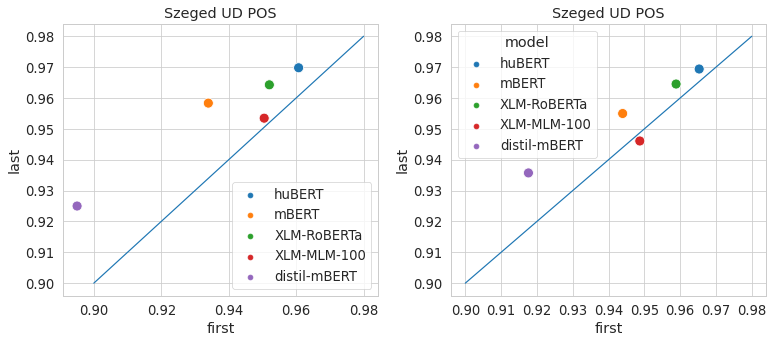

In [20]:
sns.set_style('whitegrid')
sz = szeged_pos.groupby(['model', 'subword_pooling', 'layer_pooling']).dev_acc.mean().unstack().idxmax(axis=1)
sz.name = 'best_layer'
best_layers = sz.reset_index().values
best_layers = tuple(tuple(t) for t in best_layers)

def is_best_layer(row):
    return (row.model, row.subword_pooling, row.layer_pooling) in best_layers


szeged_best = szeged_pos[szeged_pos.apply(is_best_layer, axis=1)]
szeged_best = szeged_best.groupby(['model', 'subword_pooling']).test_acc.mean().unstack(1).reset_index()

with sns.plotting_context('paper', font_scale=1.5):
    fig, axes = plt.subplots(1, 2, figsize=(11, 5))
    ax = axes[0]
    ax = sns.scatterplot(x=szeged_best['first'], y=szeged_best['last'], hue=szeged_best['model'], s=100, ax=ax)
    ax.legend(loc='lower right')
    min_ = 0.9
    max_ = 0.98
    ax.set_title("Szeged UD POS")
    ax.plot((min_, max_), (min_, max_))
    
    ax = axes[1]
    sns.scatterplot(x=p['first'], y=p['last'], hue=p['model'], s=100, ax=ax)
    ax.set_title("Large POS")
    ax.plot((min_, max_), (min_, max_))
    ax.set_title("Szeged UD POS")
    plt.tight_layout()
    fig.savefig("fig/scatter_pos.pdf")

# Morphology

In [21]:
morph = pd.read_table("../results/morph.tsv", na_filter=None, quoting=3)
model_order = [
    'huBERT',
    'mBERT',
    'XLM-RoBERTa',
    'XLM-MLM-100',
    'distil-mBERT',
]
morph['model'] = pd.Categorical(morph['model'], ordered=True, categories=model_order)
morph.head()

,model,subword_pooling,layer_pooling,task,dev_acc,test_acc
0,huBERT,first,0,case_noun,0.120370,0.111111
1,huBERT,first,0,case_noun,0.106481,0.101852
2,huBERT,first,0,case_noun,0.138889,0.115741
3,huBERT,first,0,degree_adj,0.805000,0.791045
4,huBERT,first,0,degree_adj,0.810000,0.786070


In [22]:
s = morph.groupby(['model', 'layer_pooling', 'subword_pooling', 'task']).size()
s.value_counts()

3    1496
0     484
dtype: int64

## First-last wordpiece

In [23]:
first_last = morph.groupby(['model', 'task', 'layer_pooling', 'subword_pooling']).dev_acc.mean().unstack().idxmax(axis=1)

In [24]:
m = morph.groupby(['model', 'task', 'layer_pooling', 'subword_pooling']).dev_acc.mean().unstack()
m.loc[m['first']>=m['last']]

subword_pooling                          first      last
model       task       layer_pooling                    
huBERT      degree_adj 0              0.805000  0.690000
mBERT       degree_adj 0              0.680000  0.680000
XLM-RoBERTa degree_adj 0              0.696667  0.625000
                       9              0.933333  0.926667
XLM-MLM-100 degree_adj 0              0.713333  0.645000
                       10             0.950000  0.923333
                       11             0.941667  0.936667
                       12             0.943333  0.925000
                       13             0.941667  0.930000
                       16             0.935000  0.931667
                       9              0.931667  0.928333

In [25]:
m = morph.copy()
m = m[m.layer_pooling != 'weighted_sum']
m.layer_pooling = m.layer_pooling.astype(int)
m = m[m.subword_pooling=='last']

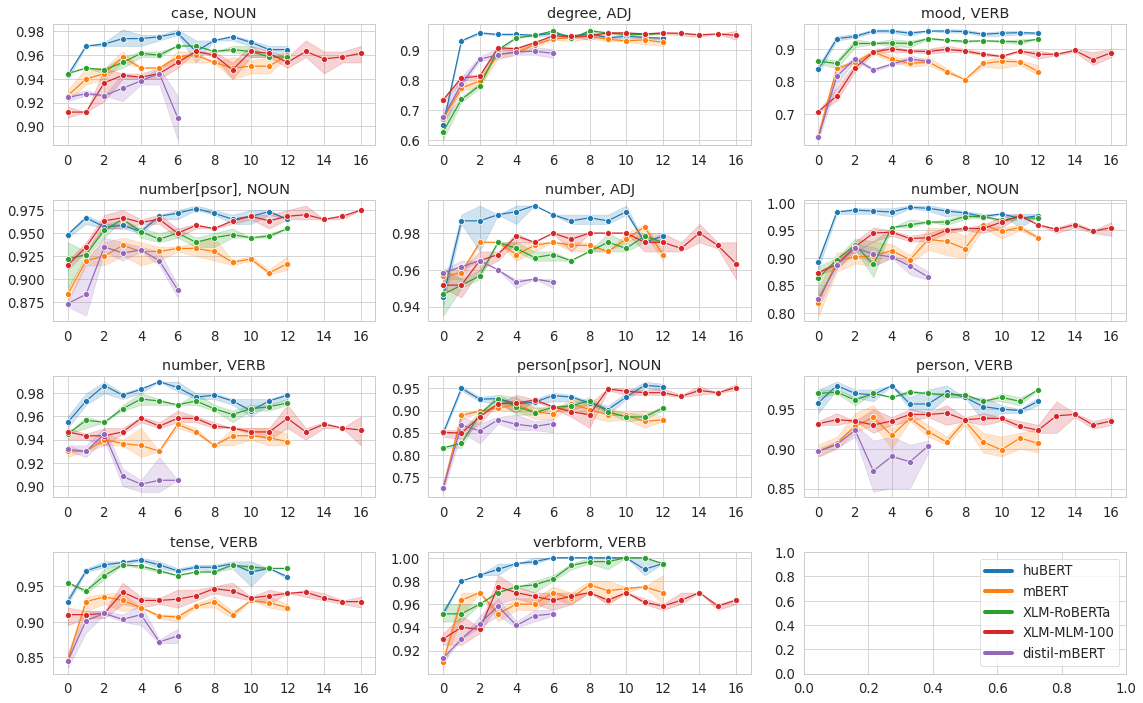

In [26]:
sns.set_style('whitegrid')
with sns.plotting_context('paper', font_scale=1.5):
    fig, axes = plt.subplots(4, 3, figsize=(16, 10))

    for ti, (task, group) in enumerate(m.groupby('task')):
        ax = axes.flat[ti]
        if ti == 0:
            sns.lineplot(x=group.layer_pooling, y=group.test_acc, hue=group.model,
                         markersize=6, marker='o', ax=ax)
            handles, labels = ax.get_legend_handles_labels()
            ax.get_legend().remove()
        else:
            sns.lineplot(x=group.layer_pooling, y=group.test_acc, hue=group.model,
                         markersize=6, marker='o', ax=ax, legend=False)
        tag, _, pos = task.partition('_')
        ax.set_title(f"{tag}, {pos.upper()}")
        ax.set_xlabel("")
        ax.set_ylabel("")
    leg = axes.flat[-1].legend(handles, labels)
    for line in leg.get_lines():
        line.set_linewidth(4.0)
    plt.tight_layout()
    fig.savefig("fig/line_morph_layerwise.pdf")

## Summary

Weighted sum

In [27]:
weighted_sum = morph[(morph.layer_pooling=='weighted_sum') & (morph.subword_pooling=='last')]
weighted_sum = weighted_sum.groupby(['model', 'task']).test_acc.mean().reset_index()

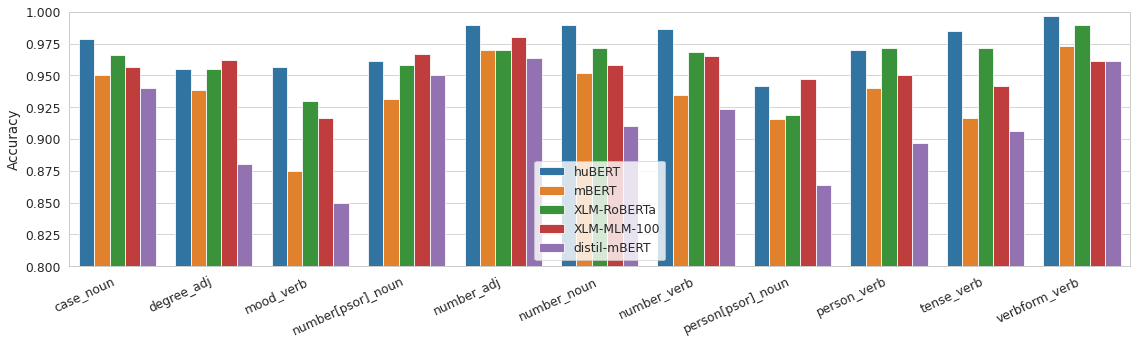

In [28]:
with sns.plotting_context('paper', font_scale=1.4):
    fig, ax = plt.subplots(1, figsize=(16, 5))
    sns.barplot(x=weighted_sum.task, y=weighted_sum.test_acc, hue=weighted_sum.model, ax=ax)
    ax.set_ylim(0.8, 1)
    ax.legend(loc='lower center')
    ax.set_xlabel("")
    ax.set_ylabel("Accuracy")
    plt.xticks(rotation=25, ha='right')
    plt.tight_layout()
    fig.savefig("fig/bar_morph_summary.pdf")

# NER

In [29]:
ner = pd.read_table("../results/ner.tsv", na_filter=None, quoting=3)
model_order = [
    'huBERT',
    'mBERT',
    'XLM-RoBERTa',
    'XLM-MLM-100',
    'distil-mBERT',
]
ner['model'] = pd.Categorical(ner['model'], ordered=True, categories=model_order)
ner.head()

,model,subword_pooling,layer_pooling,dev_acc,dev_f1,test_acc,test_f1
0,huBERT,first,0,0.983836,0.740620,0.966453,0.561319
1,huBERT,first,0,0.983572,0.741042,0.967673,0.568158
2,huBERT,first,0,0.983748,0.740016,0.967402,0.571528
3,huBERT,first,1,0.989809,0.833333,0.980107,0.715291
4,huBERT,first,1,0.990512,0.846024,0.981327,0.740518


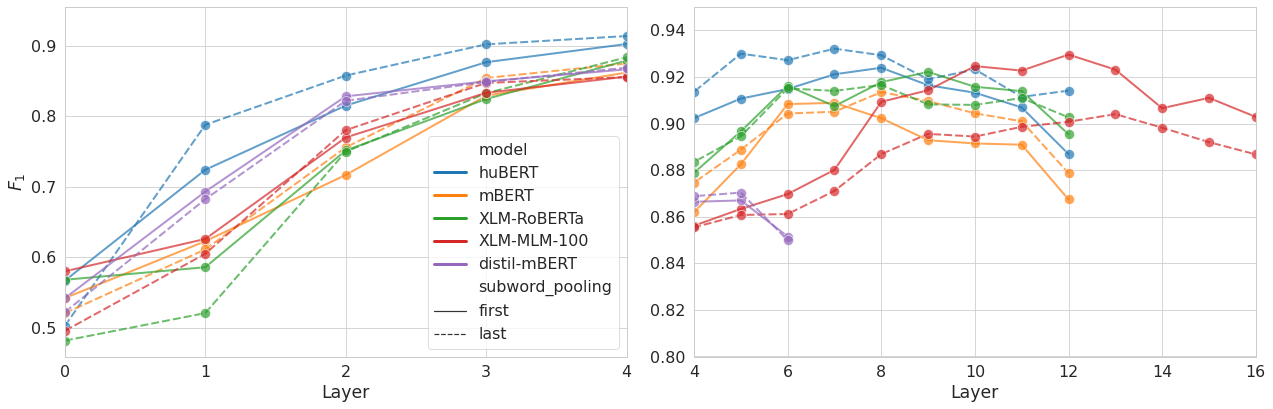

In [30]:
n = ner[ner.layer_pooling!='sum'].copy()
n.layer_pooling = n.layer_pooling.astype(int)
line_kws = dict(linewidth=2, alpha=0.7, markersize=10, marker='o', ci=None)
with sns.plotting_context('paper', font_scale=1.8):
    fig, ax = plt.subplots(1, 2, figsize=(18, 6))
    sns.lineplot(x=n.layer_pooling, y=n.test_f1, hue=n.model, style=n.subword_pooling, ax=ax[0], **line_kws)
    sns.lineplot(x=n.layer_pooling, y=n.test_f1, hue=n.model, style=n.subword_pooling, ax=ax[1], **line_kws)
    # ax[0].set_xlabel("")
    ax[0].set_xlim(0, 4)
    ax[1].set_xlim(4, 16)
    ax[1].set_ylim(0.8, 0.95)
    ax[1].set_ylabel("")
    ax[0].set_ylabel("$F_1$")
    ax[0].set_xlabel("Layer")
    ax[1].set_xlabel("Layer")
    ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
    ax[1].get_legend().set_visible(False)
    handles, labels = ax[0].get_legend_handles_labels()
    leg = ax[0].legend(handles, labels)
    for line in leg.get_lines()[:6]:
        line.set_linewidth(3.0)
    plt.tight_layout()

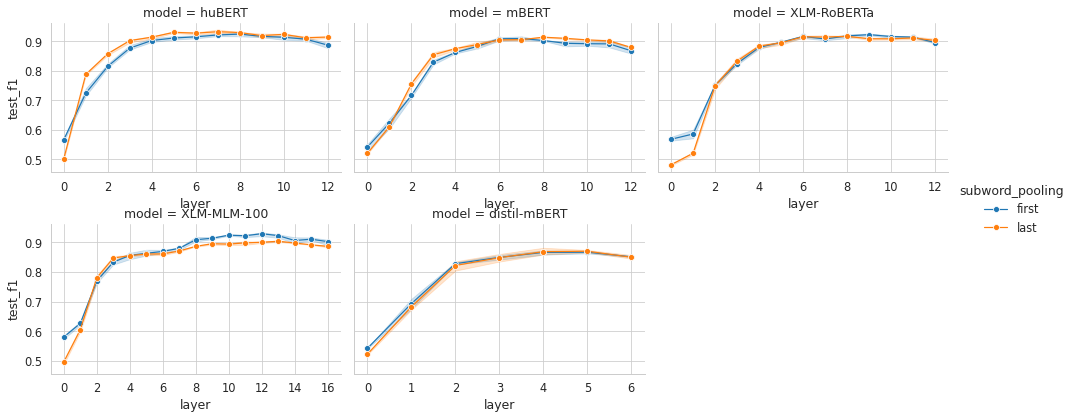

In [31]:
n = ner[ner.layer_pooling!='sum'].copy()
n.layer_pooling = n.layer_pooling.astype(int)
with sns.plotting_context('paper', font_scale=1.3):
    g = sns.FacetGrid(n[['model', 'layer_pooling', 'subword_pooling', 'test_f1']], col='model', hue='subword_pooling',
                      col_wrap=3, height=3, aspect=1.5, sharex=False)
    g.map_dataframe(sns.lineplot, x='layer_pooling', y='test_f1', markersize=6, marker='o')
    g.add_legend()
    #g.set(ylim=(0.8, 1))
    g.set(xlabel=("layer"))
    plt.savefig("fig/line_ner_layerwise.pdf")

In [32]:
lowest_layer = ner[ner.layer_pooling.astype(str)=="0"]
middle_layer = ner[ner.apply(is_middle_layer, axis=1)]
highest_layer = ner[ner.apply(is_highest_layer, axis=1)]
first_layer = ner[ner.layer_pooling.astype(str)=="1"]

lowest_layer = lowest_layer.groupby(['model', 'subword_pooling']).test_f1.mean()
lowest_layer = lowest_layer.reset_index()

first_layer = first_layer.groupby(['model', 'subword_pooling']).test_f1.mean()
first_layer = first_layer.reset_index()

middle_layer = middle_layer.groupby(['model', 'subword_pooling']).test_f1.mean()
middle_layer = middle_layer.reset_index()

highest_layer = highest_layer.groupby(['model', 'subword_pooling']).test_f1.mean()
highest_layer = highest_layer.reset_index()

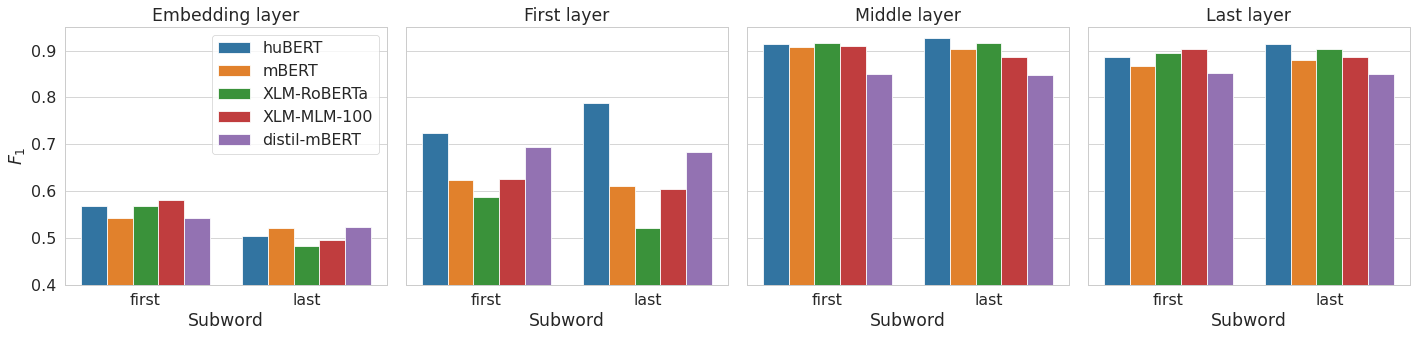

In [33]:
with sns.plotting_context('paper', font_scale=1.8):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

    sns.barplot(x=lowest_layer['subword_pooling'], y=lowest_layer['test_f1'], hue=lowest_layer['model'], ax=axes[0])
    axes[0].set_ylim(0.4, 0.95)
    axes[0].legend(markerscale=2)
    axes[0].set_title("Embedding layer")
    axes[0].set_xlabel("Subword")
    axes[0].set_ylabel("$F_1$")

    sns.barplot(x=first_layer['subword_pooling'], y=first_layer['test_f1'], hue=first_layer['model'], ax=axes[1])
    axes[1].get_legend().remove()
    #axes[1].set_ylim(94, 100)
    axes[1].set_title("First layer")
    axes[1].set_xlabel("Subword")
    axes[1].set_ylabel("")

    sns.barplot(x=middle_layer['subword_pooling'], y=middle_layer['test_f1'], hue=middle_layer['model'], ax=axes[2])
    axes[2].get_legend().remove()
    #axes[2].set_ylim(94, 100)
    axes[2].set_title("Middle layer")
    axes[2].set_xlabel("Subword")
    axes[2].set_ylabel("")

    sns.barplot(x=highest_layer['subword_pooling'], y=highest_layer['test_f1'], hue=highest_layer['model'], ax=axes[3])
    axes[3].get_legend().remove()
    axes[3].set_title("Last layer")
    axes[3].set_xlabel("Subword")
    axes[3].set_ylabel("")
    plt.tight_layout()
    
    fig.savefig("fig/bar_ner_low_high_layer.pdf")

In [34]:
ner.groupby(['model', 'subword_pooling']).apply(get_weighted_layer).unstack().round(0)

subword_pooling,first,last
model,,
huBERT,6.0,6.0
mBERT,6.0,6.0
XLM-RoBERTa,6.0,6.0
XLM-MLM-100,8.0,8.0
distil-mBERT,3.0,3.0
